In [28]:
if "running_all" not in globals():
    from ipywidgets import widgets
    matrices = ["ex10", "msc04515", "s1rmq4m1", "Na5", "bcsstk18",
                "vibrobox", "cbuckle", "Pres_Poisson", "raefsky4", "vanbody",
                "ct20stif", "cant", "bcircuit", "apache1", "consph"]
    b = widgets.Button(description="Run over all matrices", button_style="success")
    output = widgets.Output()

    display(b, output)

    def run_over_all_matrices(button):
        global running_all
        global matrix
        running_all = True
        with output:
            for matrix in matrices:
                print(f"Running {matrix}...")
                %run ./protection_vis.ipynb # will output at this cell rather than later
            print("Finished!")
    b.on_click(run_over_all_matrices)

Button(button_style='success', description='Run over all matrices', style=ButtonStyle())

Output()

In [29]:
if "running_all" not in globals():
    matrix = "vanbody"  # manually set to run over one matrix
matrix

'vanbody'

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from json import load
sys.path.append(os.path.join(os.getcwd(), os.pardir))
from io_utils import load_matrices_from_dir, load_models
from sklearn.metrics import r2_score

In [31]:
TESTING_DATA_SIZE = 1000

df = pd.read_csv(f"data/{matrix}_{TESTING_DATA_SIZE}.csv")
X_test = df[["error_iter", "pos_2norm"]].to_numpy()
y_test = df[["slowdown"]].to_numpy()
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,vanbody.mat,571,0.000001,57100,23646,500,51342,9.753510e-07,True,108.058719,4.703277e+04,47072,89.915937
1,vanbody.mat,571,0.000001,57100,26524,115,57099,1.494486e-04,False,118.780532,1.196328e+07,47072,99.998249
2,vanbody.mat,571,0.000001,57100,16697,221,57099,1.472826e-05,False,119.566583,6.948947e+06,47072,99.998249
3,vanbody.mat,571,0.000001,57100,2435,301,57099,1.333543e-05,False,120.878682,1.005238e+07,47072,99.998249
4,vanbody.mat,571,0.000001,57100,43255,338,57099,1.030199e-05,False,119.215408,3.476739e+05,47072,99.998249


In [32]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]
mat

<47072x47072 sparse matrix of type '<class 'numpy.float64'>'
	with 2329056 stored elements in Compressed Sparse Column format>

In [33]:
mat_errorfree_iters = {
    "apache1": 131, 
    "bcircuit": 48, 
    "bcsstk18": 432, 
    "cant": 394,
    "cbuckle": 341, 
    "consph": 611, 
    "ct20stif": 364, 
    "ex10": 479,
    "msc04515": 1849, 
    "Na5": 101, 
    "Pres_Poisson": 72,
    "raefsky4": 79, 
    "s1rmq4m1": 605, 
    "vanbody": 491, 
    "vibrobox": 565,
}
errorfree_iterations = mat_errorfree_iters[matrix]

In [34]:
chosen_models = {
    "apache1": "XGBRegressor",
    "bcircuit": "XGBRegressor",
    "bcsstk18": "XGBRegressor",
    "cant": "KNeighborsRegressor",
    "cbuckle": "KNeighborsRegressor",
    "consph": "Ridge",
    "ct20stif": "XGBRegressor",
    "ex10": "RandomForestRegressor",
    "msc04515": "RandomForestRegressor",
    "Na5": "XGBRegressor",
    "Pres_Poisson": "XGBRegressor",
    "raefsky4": "RandomForestRegressor",
    "s1rmq4m1": "RandomForestRegressor",
    "vanbody": "RandomForestRegressor",
    "vibrobox": "KNeighborsRegressor",
}

model_path = f"./models/{matrix}/best_{chosen_models[matrix]}.pkl"
model = load_models([model_path])[0]
df["output"] = model.predict(X_test)
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_estimators=51))])

In [35]:
with open(f"../matrices/2norms/{matrix}_pos_2norms.json") as f:
    pos_2norms = load(f)

In [36]:
# df_piv = df_full.pivot_table(index=["2norm", "rowid"], columns="i", values="output")
# df_piv.head()

In [37]:
r2 = r2_score(y_test, model.predict(X_test))
r2

0.6669987659488426

In [38]:
norms = sorted(list(df["pos_2norm"].unique()))
iters = range(errorfree_iterations)
iter_norm_pairs_spaced = np.array([[i, n, p] for p, n in enumerate(norms)
                                   for i in iters])
df_spaced = pd.DataFrame(iter_norm_pairs_spaced,
                         columns=["i", "2norm", "rowid"])
df_spaced["output"] = model.predict(df_spaced[["i", "2norm"]])
df_spaced_piv = df_spaced.pivot(index=["2norm"], columns="i", values="output")

df_spaced_piv.head()

/opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


i,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,481.0,482.0,483.0,484.0,485.0,486.0,487.0,488.0,489.0,490.0
2norm,,,,,,,,,,,,,,,,,,,,,
128.186724,1.027355,1.027355,1.027355,1.027355,1.027355,1.027355,1.027355,1.027355,1.027355,1.027355,...,1.009332,1.009332,1.009332,1.009332,1.009332,1.009332,1.009332,1.009332,1.009332,1.009744
438.588905,1.026222,1.026222,1.026222,1.026222,1.026222,1.026222,1.026222,1.026222,1.026222,1.026222,...,1.008907,1.008907,1.008907,1.008907,1.008907,1.008907,1.008907,1.008907,1.008907,1.009662
465.180653,1.026496,1.026496,1.026496,1.026496,1.026496,1.026496,1.026496,1.026496,1.026496,1.026496,...,1.009044,1.009044,1.009044,1.009044,1.009044,1.009044,1.009044,1.009044,1.009044,1.009799
699.618554,1.038529,1.038529,1.038529,1.038529,1.038529,1.038529,1.038529,1.038529,1.038529,1.038529,...,1.031046,1.031046,1.031046,1.031046,1.031046,1.031046,1.031046,1.031046,1.031046,1.031802
773.860616,1.078981,1.078981,1.078981,1.078981,1.078981,1.078981,1.078981,1.078981,1.078981,1.078981,...,1.096477,1.096477,1.096477,1.096477,1.096477,1.096477,1.096477,1.096477,1.096477,1.097164


In [39]:
ylim = (min(norms), max(norms))
if matrix == "vanbody":
    ylim = (min(norms), 10**8 * 5)

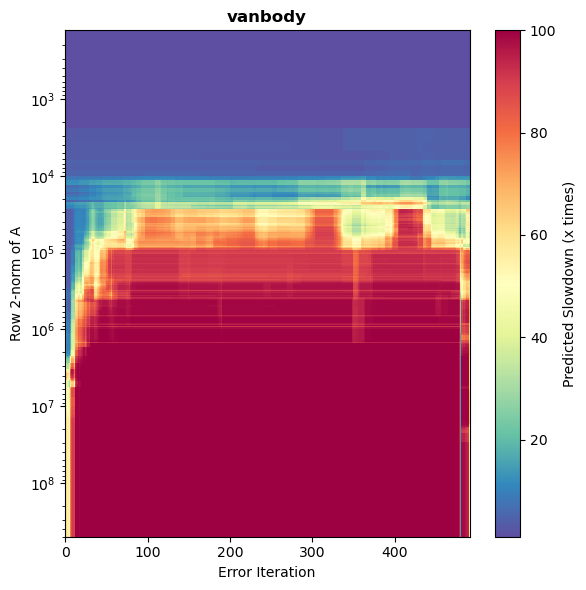

In [40]:
plt.gcf().set_size_inches(6, 6)
plt.gcf().set_dpi(100)

y, x = np.meshgrid(norms, iters)
norm = plt.Normalize(1, 100)
ax = plt.pcolormesh(x, y, df_spaced_piv.to_numpy().T,
                    cmap="Spectral_r", norm=norm, shading="nearest")
sm = plt.cm.ScalarMappable(cmap="Spectral_r", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, ax=plt.gca(), label="Predicted Slowdown (x times)")

plt.ylim(ylim)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.xlabel("Error Iteration")
plt.ylabel("Row 2-norm of A")
plt.title(f"{matrix}", weight="bold")
plt.tight_layout()
plt.savefig(f"./figures/{matrix}/iter_r2n_output.png")
plt.show()

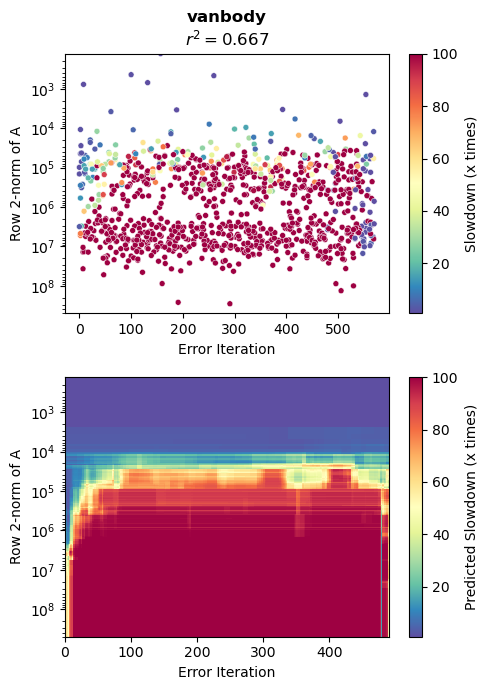

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.set_size_inches(5, 7)
fig.set_dpi(100)

scatter = sns.scatterplot(df, ax=ax1, x="error_iter", y="pos_2norm",
                     hue="slowdown", legend=False, palette="Spectral_r", size=1)
norm = plt.Normalize(1, 100)
sm = plt.cm.ScalarMappable(cmap="Spectral_r", norm=norm)
sm.set_array([])
scatter.figure.colorbar(sm, ax=scatter, label="Slowdown (x times)")

ax1.set_yscale("log")
ax1.set_ylim(ylim)
scatter.invert_yaxis()
ax1.set_xlabel("Error Iteration")
ax1.set_ylabel("Row 2-norm of A")

y, x = np.meshgrid(norms, iters)
norm = plt.Normalize(1, 100)
heatmap = plt.pcolormesh(x, y, df_spaced_piv.to_numpy().T,
                    cmap="Spectral_r", norm=norm, shading="nearest")
sm = plt.cm.ScalarMappable(cmap="Spectral_r", norm=norm)
sm.set_array([])
heatmap.figure.colorbar(sm, ax=ax2, label="Predicted Slowdown (x times)")

ax2.set_ylim(ylim)
ax2.set_yscale("log")
ax2.invert_yaxis()
ax2.set_xlabel("Error Iteration")
ax2.set_ylabel("Row 2-norm of A")

ax1.set_title(f"{matrix}\n$r^2 = {round(r2, 3)}$", weight="bold")
plt.tight_layout()
plt.savefig(f"./figures/{matrix}/fit_combined.png")
plt.show()

In [42]:
df_full = pd.DataFrame([[i, pos_2norms[str(pos)], pos] for pos in range(mat.shape[0])
                   for i in range(errorfree_iterations)], columns=["i", "2norm", "rowid"])
df_full["output"] = model.predict(df_full[["i", "2norm"]])


df_piv_rowid = df_full.pivot(index=["rowid"], columns="i", values="output")
df_piv_rowid.head()

/opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


i,0,1,2,3,4,5,6,7,8,9,...,481,482,483,484,485,486,487,488,489,490
rowid,,,,,,,,,,,,,,,,,,,,,
0,17.423749,19.005872,27.115793,25.641616,25.207256,30.172728,35.427286,55.198242,70.693520,71.148999,...,99.232013,99.232013,99.232013,99.232013,99.423550,99.423550,99.423550,99.423550,99.423550,61.076366
1,5.556712,6.497785,6.723327,3.953249,3.584165,2.874842,3.592838,7.606270,17.418021,19.541911,...,56.316102,53.591829,60.233708,60.233708,62.000939,62.000939,66.418539,66.418539,65.041054,57.673227
2,4.005220,4.005220,3.952715,3.741733,3.681158,3.613269,3.689331,4.208406,4.835651,5.169259,...,28.945859,30.546937,26.610843,26.610843,29.722011,29.724106,41.080543,40.852449,40.852449,33.399781
3,17.423749,19.005872,27.115793,25.641616,25.207256,30.172728,35.427286,55.198242,70.693520,71.148999,...,99.232013,99.232013,99.232013,99.232013,99.423550,99.423550,99.423550,99.423550,99.423550,61.076366
4,4.648630,5.143977,5.488951,3.593603,3.209684,2.697136,3.109372,7.110271,14.502016,17.113458,...,53.394487,51.996278,57.947385,61.249184,61.249184,61.249184,64.164615,64.164615,62.787130,59.747298


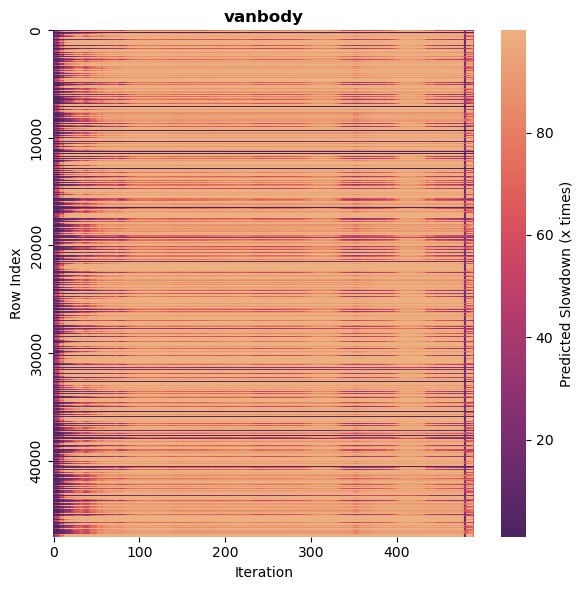

In [43]:
plt.gcf().set_size_inches(6, 6)
plt.gcf().set_dpi(100)

xskip = 20 if errorfree_iterations < 200 else 100
yskip = 1000 if mat.shape[0] < 10000 else 2000 if mat.shape[0] < 20000 else 10000
ax = sns.heatmap(df_piv_rowid, vmin=1, vmax=df_full["output"].max(), cmap="flare_r", xticklabels=xskip,
            yticklabels=yskip, cbar_kws={"label": "Predicted Slowdown (x times)"})

plt.xlabel("Iteration")
plt.ylabel("Row Index")
plt.title(f"{matrix}", weight="bold")
plt.tight_layout()
plt.savefig(f"./figures/{matrix}/protection_scheme.png")
plt.show()

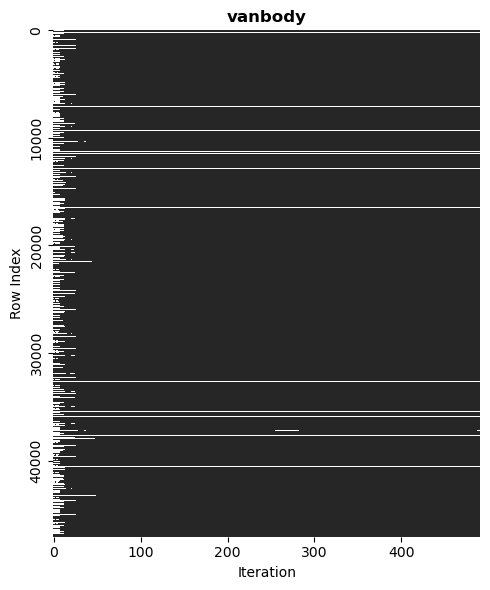

In [44]:
plt.gcf().set_size_inches(5, 6)
plt.gcf().set_dpi(100)

p = 0.1
color = sns.color_palette("dark:white_r", as_cmap=True)

xskip = 20 if errorfree_iterations < 200 else 100
yskip = 1000 if mat.shape[0] < 10000 else 2000 if mat.shape[0] < 20000 else 10000
ax = sns.heatmap(df_piv_rowid > (1 + (1 / p)), vmin=0, vmax=1, cmap=color, cbar=False, 
                 xticklabels=xskip, yticklabels=yskip)

plt.xlabel("Iteration")
plt.ylabel("Row Index")
plt.title(f"{matrix}", weight="bold")
plt.tight_layout()
plt.savefig(f"./figures/{matrix}/binary_protection_scheme.png")
plt.show()